In [98]:
import pandas as pd
import matplotlib as mpl
import circlify as circ
import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import *

## Load and Inspect Data

In [99]:
df = pd.read_json('../data/complaints.json')
df = df.sample(10000).reset_index(drop=True)
df.head()

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,4156514,0,"{'tags': None, 'zip_code': None, 'complaint_id..."
1,complaint-public-v2,complaint,2262867,0,"{'tags': None, 'zip_code': None, 'complaint_id..."
2,complaint-public-v2,complaint,2288068,0,"{'tags': None, 'zip_code': '91770', 'complaint..."
3,complaint-public-v2,complaint,3335046,0,"{'tags': None, 'zip_code': '07016', 'complaint..."
4,complaint-public-v2,complaint,161266,0,"{'tags': None, 'zip_code': '89120', 'complaint..."


Once we normalize the json in our _source column, we can get all of the complaint information.

In [100]:
new_df = pd.json_normalize(df['_source'])
new_df = new_df[~(new_df['complaint_what_happened'] == '')]
new_df.head(3)

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,None,4156514,Problem with a lender or other company chargin...,2021-02-22T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2021-02-22T12:00:00-05:00,None,Checking account,Yes,On XX/XX/XXXX I sent this letter to the Feds :...,Transaction was not authorized,Consent provided
14,None,None,2333889,"Loan servicing, payments, escrow account",2017-02-08T12:00:00-05:00,CA,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-02-08T12:00:00-05:00,None,Reverse mortgage,Yes,I took this real estate loan out with a loan c...,None,Consent provided
17,None,None,1611176,Credit decision / Underwriting,2015-10-16T12:00:00-05:00,NY,Yes,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-10-16T12:00:00-05:00,None,Conventional fixed mortgage,Yes,Chase bank issued a loan modification to my fo...,None,Consent provided


Lets create a new dataframe with just the complaints and their respective ids.

In [101]:
complaints_df = new_df[['complaint_id', 'complaint_what_happened']]
complaints_df.head()

,complaint_id,complaint_what_happened
0,4156514,On XX/XX/XXXX I sent this letter to the Feds :...
14,2333889,I took this real estate loan out with a loan c...
17,1611176,Chase bank issued a loan modification to my fo...
19,4181483,My Chase United Card ending XXXX notified me i...
21,1473454,I opened a checking account at Chase Bank in X...


## Process Data
***
Here we clean and process our dataset for exploratory data analysis and visualizations.

In [102]:
complaints_df = complaints_df.copy()
complaints_df.rename(columns={'complaint_what_happened': 'complaint'}, inplace=True)

In [103]:
complaints_df.head()

,complaint_id,complaint
0,4156514,On XX/XX/XXXX I sent this letter to the Feds :...
14,2333889,I took this real estate loan out with a loan c...
17,1611176,Chase bank issued a loan modification to my fo...
19,4181483,My Chase United Card ending XXXX notified me i...
21,1473454,I opened a checking account at Chase Bank in X...


Using the clean function provided in utils.utils, we can transform the text to lowercase and remove unwanted punctuation and placeholders.

In [104]:
complaints_df.loc[:, 'complaint'] = complaints_df['complaint'].apply(clean)
complaints_df.head()

,complaint_id,complaint
0,4156514,on i sent this letter to the feds hello i n...
14,2333889,i took this real estate loan out with a loan c...
17,1611176,chase bank issued a loan modification to my fo...
19,4181483,my chase united card ending notified me in i...
21,1473454,i opened a checking account at chase bank in ...


The noun extraction uses Part-Of-Speech tagging, POS, to extract nouns from the text. This is then stored back into the dataframe in a new column.

In [105]:
complaints_df.loc[:, 'clean_text'] = complaints_df['complaint'].apply(noun_extraction)
complaints_df.head()

,complaint_id,complaint,clean_text
0,4156514,on i sent this letter to the feds hello i n...,letter help business banking i fee bank credit...
14,2333889,i took this real estate loan out with a loan c...,i estate loan loan cap limit life loan i close...
17,1611176,chase bank issued a loan modification to my fo...,bank loan modification husband separation docu...
19,4181483,my chase united card ending notified me in i...,chase card i payment i account delay online ac...
21,1473454,i opened a checking account at chase bank in ...,i checking account bank time i total bank disp...


This pipeline is defined in utils.utils and allows efficient transforms on our text. We can get topics using NMF, word vectors using TF-IDF and word frequency using Count Vectorizer.

In [106]:
pipe = vectorizer_pipeline(complaints_df.clean_text)

**Topic Map** simply maps the label to the respective topic. Decided after the following steps.

In [107]:
topic_map = {
    0: 'Bank account services',
    1: 'Theft / Dispute reporting',
    2: 'Mortgages / Loans',
    3: 'Credit card / Prepaid card',
    4: 'Others'
}

Here I allocate a 5x10 array for holding words for a given topic. 
- NMF provides this information through the components_ which gives the relationship between words and the 5 components (topics).
- This allows us to see which are the most common words for each topic, and we can organize our information into the topics listed above.

In [108]:
topic_term_matrix = pipe['nmf'].components_
words = pipe['count'].get_feature_names_out()

topics = [['']*10 for _ in range(5)]
for i in range(5):
    index = topic_term_matrix[i].argsort()[::-1][:10]
    topics[i] = words[index]

topic_words = pd.DataFrame(topics, index=[''  for i in range(5)], columns=[f'Word {i+1}' for i in range(10)])
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
,account,bank,money,chase,check,transaction,branch,claim,fraud,number
,credit,card,report,chase,inquiry,company,letter,score,information,dispute
,loan,mortgage,chase,modification,home,foreclosure,property,process,time,letter
,payment,credit,month,bank,auto,time,date,account,day,report
,balance,interest,statement,fee,transfer,rate,card,amount,month,chase


We can also get the cluster assignments but taking the output of nmf and using argmax to find the top topic for each word.

In [109]:
nmf_output = pipe['nmf'].transform(
    pipe['tfidf'].transform(pipe['count'].transform(complaints_df.clean_text))
)

cluster_assignments = np.argmax(nmf_output, axis=1)
complaints_df.loc[:, 'label'] = cluster_assignments
complaints_df.loc[:, 'topic'] = complaints_df['label'].map(topic_map)

complaints_df.head()

,complaint_id,complaint,clean_text,label,topic
0,4156514,on i sent this letter to the feds hello i n...,letter help business banking i fee bank credit...,0,Bank account services
14,2333889,i took this real estate loan out with a loan c...,i estate loan loan cap limit life loan i close...,2,Mortgages / Loans
17,1611176,chase bank issued a loan modification to my fo...,bank loan modification husband separation docu...,2,Mortgages / Loans
19,4181483,my chase united card ending notified me in i...,chase card i payment i account delay online ac...,4,Others
21,1473454,i opened a checking account at chase bank in ...,i checking account bank time i total bank disp...,0,Bank account services


## Data Visualization

Using these topic dataframes, we can plot aggregate results for a given topic.

In [110]:
topic_dfs = {
    topic_map[label]: complaints_df[complaints_df['label'] == label] \
    for label in topic_map
}

### Circle Packing Diagram for Relative Word Frequency

Here we generate a Circle Packing Diagram to represent relative word frequency. It uses the **circlify** library to create circles representing words, with the size of each circle indicating its frequency. These circles are organized hierarchically. The code iterates through different topics, generating circles for the most frequent words associated with each topic. The background color of the figure is set to white.

In this visualization:
- Each circle represents a word.
- The size of a circle corresponds to its frequency in the corpus.
- Circles are organized hierarchically, with larger circles encompassing smaller ones.
- By default only one topic is shown.

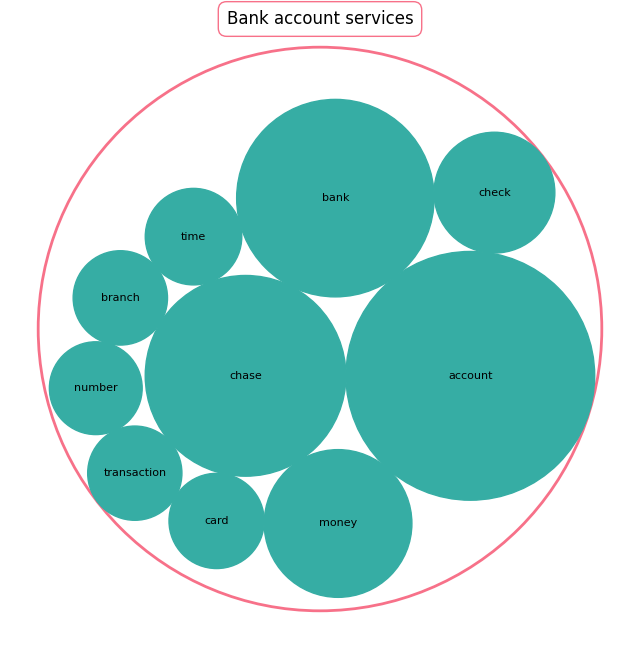

In [111]:
bg_color = 'white'
# bg_color = sns.dark_palette('#00044f')[2]

k=10
# Assuming you're working with the first topic (index 0)
# topic = 'Theft / Dispute reporting'
fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor(bg_color)
offset = 2.5
positions = [(0, 0), (offset, 0), (-offset, 0), (0, offset), (0, -offset)]

for topic, position in zip(topic_map.values(), positions):
    data = topic_dfs[topic]
    feature_names = pipe['count'].get_feature_names_out()
    word_counts = pipe['count'].transform(data['clean_text']).sum(axis=0)

    topic_data = pd.DataFrame({
        'Word': feature_names, 
        'Count': word_counts.tolist()[0]
    }).sort_values(by='Count', ascending=False)


    values = topic_data['Count'].values.tolist()[:k]
    labels = topic_data['Word'].values.tolist()[:k][::-1]

    edge = sns.color_palette('husl')[3]
    face = sns.color_palette('husl')[3]

    # Generate circular packing using circlify
    circles = circ.circlify(values, show_enclosure=True, target_enclosure=None)

    # Draw the big circle encompassing all k words
    big_circle = circles[0]
    x, y, r = big_circle.circle
    plt.gca().add_patch(plt.Circle((x+position[0], y+position[1]), r, fill=False, edgecolor=sns.color_palette('husl')[0], linewidth=2))
    plt.text(x+position[0], y+position[1]+1.1, topic, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor=bg_color, edgecolor=sns.color_palette('husl')[0], boxstyle='round', pad=.5))

    for circle, label in zip(circles[1:], labels):
        x, y, r = circle.circle
        plt.gca().add_patch(plt.Circle((x+position[0], y+position[1]), r, fill=True, edgecolor=edge, facecolor=face))
        plt.text(x+position[0], y+position[1], label, ha='center', va='center', fontsize=8)
    
    break

    # break

plt.axis('equal')
plt.axis('off')
plt.show()

### Donut Chart for Class Distribution

This Python code generates a Donut Chart, a variant of a pie chart, used to visualize class distribution. 

In this visualization:
- Each slice of the donut represents a different class.
- The size of each slice corresponds to the proportion of data points in that class.

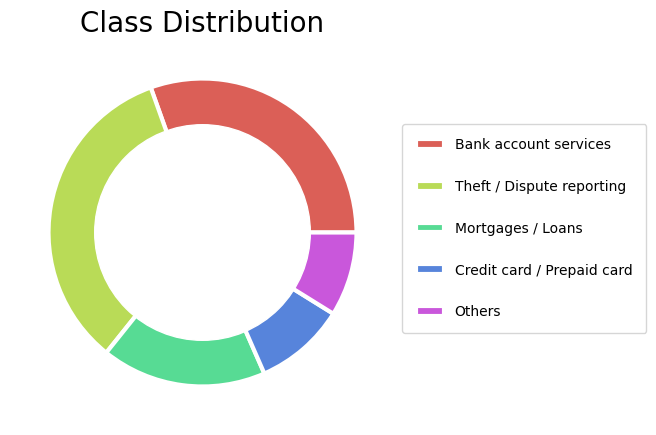

In [112]:
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['font.weight'] = 'normal'

size_of_groups=[len(complaints_df[complaints_df.label == i]) for i in range(5)]


plt.figure(facecolor=bg_color, figsize=(10, 5))

plt.pie(
    size_of_groups, 
    colors=sns.color_palette('hls', 5), 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : bg_color }
)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color=bg_color)

plt.gca().add_artist(my_circle)
plt.legend(topic_map.values(), loc='upper left', bbox_to_anchor=(1,0.8), labelspacing=2, borderpad=1)
plt.title('Class Distribution', fontdict={'fontsize': 20}, color='black')
plt.show()